<h1> Amazon Food Reviews

We have Amazon Food Reviews with 10 features

1.Id

2.Product Id

3.UserID

4.Profile Name

5.Helpfulness Numerator

6.Helpfulness Denominator

7.Score

8.Time

9.Summary

10.Text

# Objective

We have 10 features from that we will use text feature to predict given review is positive or negative

# Positive and Negative conversion

Here we are considering the 0 for negative reviews which has score less than 3 and 1 for positive reviews which has score greater than 3 and we are leaving the neutral reviews

In [1]:
!pip install -U -q PyDrive ## you will have install for every colab session

    100% |████████████████████████████████| 993kB 21.8MB/s 


In [0]:
#imports for authentication google colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
# importing datase file using drive file sharable link
database_file = drive.CreateFile({'id':'18NszCAf4A-geCy2OXeG9CtckB65fy6_8'})
database_file.GetContentFile('database.sqlite')


In [0]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [6]:
# using sqlite3 we have import data of Amazon food reviews from database
import sqlite3
connection = sqlite3.connect('database.sqlite')

food_data = pd.read_sql_query('select * from reviews ',connection)

food_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
food_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Here we are leaving neutral reviews which has score 3
food_data = pd.read_sql_query('select * from reviews where score != 3',connection)


In [0]:
# Here are replacing review score 1,2 as 0 and 4,5 as a 1.
# O is Negative reviews
# 1 is positive reviews
def partition(x):
    if x<3:
        return 0
    return 1

actualScore = food_data['Score']
positiveNegative = actualScore.map(partition)
food_data['Score'] = positiveNegative

In [10]:
# check the score
food_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
#Drop the duplicates from data and also helpfulness numerator is always lessthan helpfulness denominator
final = food_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

final = final[final['HelpfulnessNumerator'] <=final['HelpfulnessDenominator']  ]


In [12]:
!pip install nltk

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [0]:
final['FinalText'] = final_string
final['FinalText'] = final['FinalText'].str.decode('utf-8')

con  = sqlite3.connect('final_reviews.sqlite')

c = con.cursor()
con.text_factory = str

final.to_sql('Reviews', con,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [0]:
final_data = final.sample(n=100000)

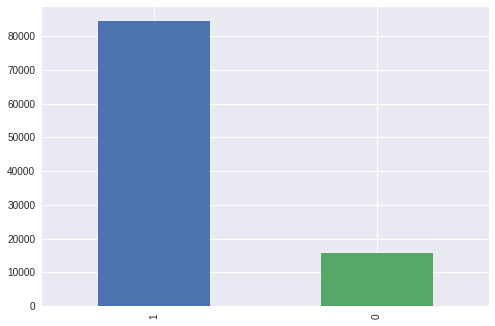

In [17]:
final_data['Score'].value_counts().plot(kind = 'bar')

#Naive Bayes Classifier

#Apply Bag Of words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = final_data['FinalText'].values
y = final_data['Score'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)

In [19]:
# try count vectorizer

bow = CountVectorizer()

X_train_bow = bow.fit_transform(X_train)

X_train_bow = preprocessing.normalize(X_train_bow)

X_test_bow = bow.transform(X_test)

X_test_bow = preprocessing.normalize(X_test_bow)

X_cv_bow = bow.transform(X_cv)

X_cv_bow = preprocessing.normalize(X_cv_bow)

print("Shape of independent varibles")
print(X_train_bow.shape)
print(X_test_bow.shape)
print(X_cv_bow.shape)

print("Shape of dependent varibles")
print(y_train.shape)
print(y_test.shape)
print(y_cv.shape)



Shape of independent varibles
(44890, 26095)
(33000, 26095)
(22110, 26095)
Shape of dependent varibles
(44890,)
(33000,)
(22110,)


#Hyperparameter tuning

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

cv_scores = []

train_scores = []

i=0

for a in alpha:
  multiNB = MultinomialNB(alpha = a)
  multiNB.fit(X_train_bow,y_train)
  scores = roc_auc_score(np.array(y_cv),multiNB.predict_proba(X_cv_bow)[:,1])
  cv_scores.append(scores)
  scores = roc_auc_score(np.array(y_train),multiNB.predict_proba(X_train_bow)[:,1])
  train_scores.append(scores)
  
  print("Cv scores {} and train Scores {} alpha {}".format(cv_scores[i],train_scores[i],a))
  i +=1
 
  
  
  


Cv scores 0.8606965875511435 and train Scores 0.9781650032690492 alpha 1e-05
Cv scores 0.8838478037732653 and train Scores 0.9770621783664217 alpha 0.0001
Cv scores 0.907242024865822 and train Scores 0.9748294559289173 alpha 0.001
Cv scores 0.9262034459121267 and train Scores 0.9696987690495694 alpha 0.01
Cv scores 0.9330799746159493 and train Scores 0.9569375472692427 alpha 0.1
Cv scores 0.9039336736443507 and train Scores 0.9143577313960183 alpha 1
Cv scores 0.7497245903534913 and train Scores 0.753585020546704 alpha 10
Cv scores 0.6818128766861781 and train Scores 0.6815615272123995 alpha 100
Cv scores 0.6499506252729027 and train Scores 0.6483698426770687 alpha 1000


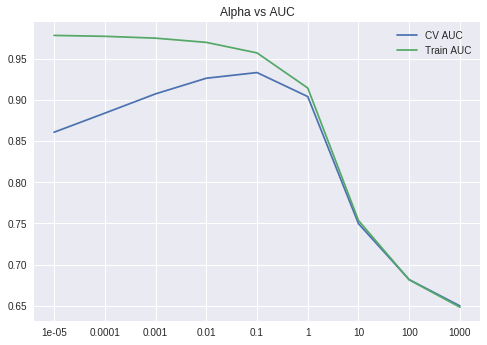

In [60]:
plt.title("Alpha vs AUC")
plt.plot(range(len(alpha)),cv_scores,label = "CV AUC")
plt.plot(range(len(alpha)),train_scores,label = "Train AUC")
plt.xticks(range(len(alpha)),alpha)
plt.legend()
plt.show()

In [23]:
# fit the model with best alpha
multiNB = MultinomialNB(alpha = 0.01)
multiNB.fit(X_train_bow,y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [0]:
pred = multiNB.predict(X_test_bow)

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
def plot_confusion_matrix(data1,data2):
    cm = confusion_matrix(data1,data2)
    labels = ['negative','positive']
    sn.heatmap(cm, annot=True, xticklabels = labels, yticklabels = labels,fmt='g')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Original Label")
    plt.show()

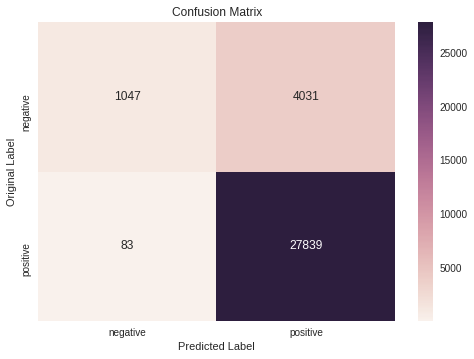

In [26]:
plot_confusion_matrix(y_test,pred)

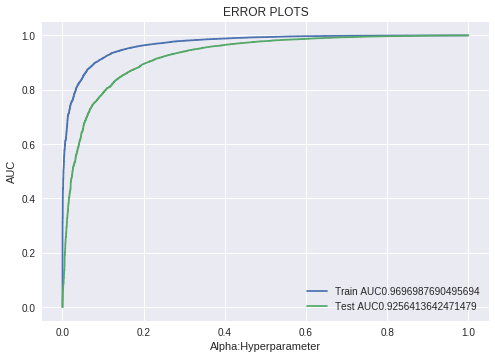

In [27]:
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,thresholds = roc_curve(y_train,multiNB.predict_proba(X_train_bow)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,multiNB.predict_proba(X_test_bow)[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC"+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test AUC"+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("Alpha:Hyperparameter")
plt.ylabel("AUC") 
plt.title("ERROR PLOTS")
plt.show()

#Postive and Negative Class Top 10 features

In [0]:
features = pd.DataFrame(data = multiNB.feature_log_prob_.T,index=bow.get_feature_names(), columns=['negative','positive'])
positive_features = features.sort_values(by='positive', ascending=False)[0:10]
negative_features = features.sort_values(by='negative', ascending=False)[0:10]


In [52]:
positive_features

,negative,positive
like,-4.243731,-4.410216
tast,-4.086586,-4.413325
love,-5.569773,-4.421187
great,-5.917212,-4.456688
good,-4.946944,-4.492576
flavor,-4.744969,-4.609720
product,-4.364717,-4.697014
use,-5.085779,-4.703895
one,-4.723411,-4.802537
tri,-4.850635,-4.880493


In [53]:
negative_features

,negative,positive
tast,-4.086586,-4.413325
like,-4.243731,-4.410216
product,-4.364717,-4.697014
one,-4.723411,-4.802537
flavor,-4.744969,-4.609720
tri,-4.850635,-4.880493
would,-4.865116,-5.335811
good,-4.946944,-4.492576
buy,-4.967000,-5.215527
coffe,-5.051741,-4.962818


# Apply TFIDF 

In [66]:
# try count vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range = (1,2))

X_train_tfidf = tfidf.fit_transform(X_train)

X_train_tfidf = preprocessing.normalize(X_train_tfidf)

X_test_tfidf = tfidf.transform(X_test)

X_test_tfidf = preprocessing.normalize(X_test_tfidf)

X_cv_tfidf = tfidf.transform(X_cv)

X_cv_tfidf = preprocessing.normalize(X_cv_tfidf)

print("Shape of independent varibles")
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(X_cv_tfidf.shape)

print("Shape of dependent varibles")
print(y_train.shape)
print(y_test.shape)
print(y_cv.shape)

Shape of independent varibles
(44890, 726866)
(33000, 726866)
(22110, 726866)
Shape of dependent varibles
(44890,)
(33000,)
(22110,)


In [67]:
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

cv_scores = []

train_scores = []

i=0

for a in alpha:
  multiNB = MultinomialNB(alpha = a)
  multiNB.fit(X_train_tfidf,y_train)
  scores = roc_auc_score(np.array(y_cv),multiNB.predict_proba(X_cv_tfidf)[:,1])
  cv_scores.append(scores)
  scores = roc_auc_score(np.array(y_train),multiNB.predict_proba(X_train_tfidf)[:,1])
  train_scores.append(scores)
  
  print("Cv scores {} and train Scores {} alpha {}".format(cv_scores[i],train_scores[i],a))
  i +=1
 
  
  
  


Cv scores 0.8286171668804495 and train Scores 0.9999997726241818 alpha 1e-05
Cv scores 0.8515482271585326 and train Scores 0.9999997502593473 alpha 0.0001
Cv scores 0.8839716042549235 and train Scores 0.9999996123428673 alpha 0.001
Cv scores 0.9203630808146022 and train Scores 0.999998468008832 alpha 0.01
Cv scores 0.9181884170288552 and train Scores 0.9997678231973646 alpha 0.1
Cv scores 0.7906129337086798 and train Scores 0.9307674963763097 alpha 1
Cv scores 0.7019411636972914 and train Scores 0.7559002543138886 alpha 10
Cv scores 0.6618628159434716 and train Scores 0.6857299111722074 alpha 100
Cv scores 0.6470764113904861 and train Scores 0.663791887103329 alpha 1000


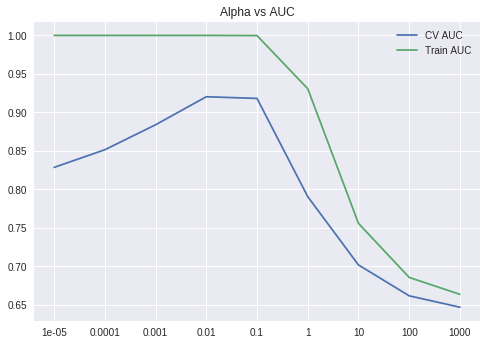

In [68]:
plt.title("Alpha vs AUC")
plt.plot(range(len(alpha)),cv_scores,label = "CV AUC")
plt.plot(range(len(alpha)),train_scores,label = "Train AUC")
plt.xticks(range(len(alpha)),alpha)
plt.legend()
plt.show()

In [69]:
multiNB = MultinomialNB(alpha = 0.1)
multiNB.fit(X_train_tfidf,y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [0]:
 pred = multiNB.predict(X_test_tfidf)

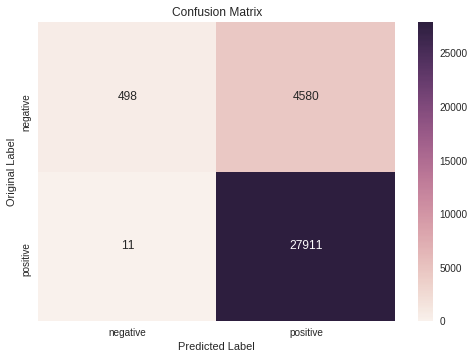

In [71]:
plot_confusion_matrix(y_test,pred)

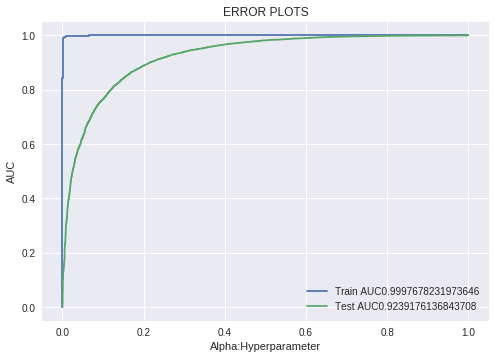

In [72]:
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,thresholds = roc_curve(y_train,multiNB.predict_proba(X_train_tfidf)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,multiNB.predict_proba(X_test_tfidf)[:,1])
plt.plot(train_fpr,train_tpr,label="Train AUC"+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr,test_tpr,label="Test AUC"+str(auc(test_fpr,test_tpr)))
plt.legend()
plt.xlabel("Alpha:Hyperparameter")
plt.ylabel("AUC") 
plt.title("ERROR PLOTS")
plt.show()

#Get top 10 Postive class and negative features

In [0]:
features = pd.DataFrame(data = multiNB.feature_log_prob_.T,index=tfidf.get_feature_names(), columns=['negative','positive'])
positive_features = features.sort_values(by='positive', ascending=False)[0:10]
negative_features = features.sort_values(by='negative', ascending=False)[0:10]


In [74]:
positive_features

,negative,positive
love,-8.220225,-6.421106
great,-8.541558,-6.424119
tast,-6.804795,-6.476228
like,-6.966108,-6.481654
good,-7.604122,-6.498021
tea,-7.618679,-6.521716
flavor,-7.327803,-6.545738
coffe,-7.331321,-6.586403
use,-7.669609,-6.638739
product,-6.979092,-6.649988


In [75]:
negative_features

,negative,positive
tast,-6.804795,-6.476228
like,-6.966108,-6.481654
product,-6.979092,-6.649988
one,-7.324016,-6.747760
flavor,-7.327803,-6.545738
would,-7.328294,-7.141155
coffe,-7.331321,-6.586403
tri,-7.423863,-6.799505
buy,-7.433813,-7.023799
order,-7.462088,-7.072065


In [0]:
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ['Type','Train_AUC','Test_AUC',]

table.add_row(['Bag Of Words',96.96,92.56])
table.add_row(['TFIDF',99.97,92.39,])

In [77]:
print(table)

+--------------+-----------+----------+
|     Type     | Train_AUC | Test_AUC |
+--------------+-----------+----------+
| Bag Of Words |   96.96   |  92.56   |
|    TFIDF     |   99.97   |  92.39   |
+--------------+-----------+----------+


The model with Bag of Words doing well and has highest test accuracy